Pre-COVID19

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github')))
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github/Method')))
import copy
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from collections import namedtuple
from Baseline import (set_seed,three_freq_midas_lagged_neural,midas_forecast_neural)
from utils import (root_mean_squared_error, mean_absolute_error, print_stats, plot_forecasts_multi)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

np.printoptions(precision=4, suppress=True)
np.set_printoptions(precision=4, suppress=True)
set_seed(42)

#data parameters
d1 = 20
d2 = 3
P1 = 13
P2 = 56
QP3 = 9
Q = 5

T = 188
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

#hyperparameters
r1_list =  list(range(1, 9))
r2_list = list(range(1, 7))
# k_list =  list(range(1, 7)) #lag
k_list = [1, 4, 8, 12]
r1_num = len(r1_list)
r2_num = len(r2_list)
k_num = len(k_list)
epochs = 200

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print_stats(Y, 'Y')
print_stats(X_M, 'X_M')
print_stats(X_H, 'X_H')

# --- Data Splitting ---
X_H_train = X_H[:, :(T_train + T_val) * d1 * d2]
X_M_train = X_M[:, :(T_train + T_val) * d2]
Y_train = Y[:, :(T_train + T_val)]

X_H_test = X_H[:, T_train * d1 * d2 + T_val * d1 * d2:]
X_M_test = X_M[:, T_train * d2 + T_val * d2:]
Y_test = Y[:, T_train + T_val:]

T 188 T_H: 11280 T_M: 564
T_train: 148 T_val: 20 T_test: 20
--- Y ---
Shape: (9, 188)
Stat: max=9.0831  min=-4.5942  mean=0.0039  std=0.8721
--- X_M ---
Shape: (56, 564)
Stat: max=16.9403  min=-17.1282  mean=0.0004  std=0.8662
--- X_H ---
Shape: (13, 11280)
Stat: max=23.1950  min=-25.5649  mean=0.0001  std=0.9700


Test3 (MIDAS+ DNN/RNN/LSTM/GRU/Transformer)


----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0

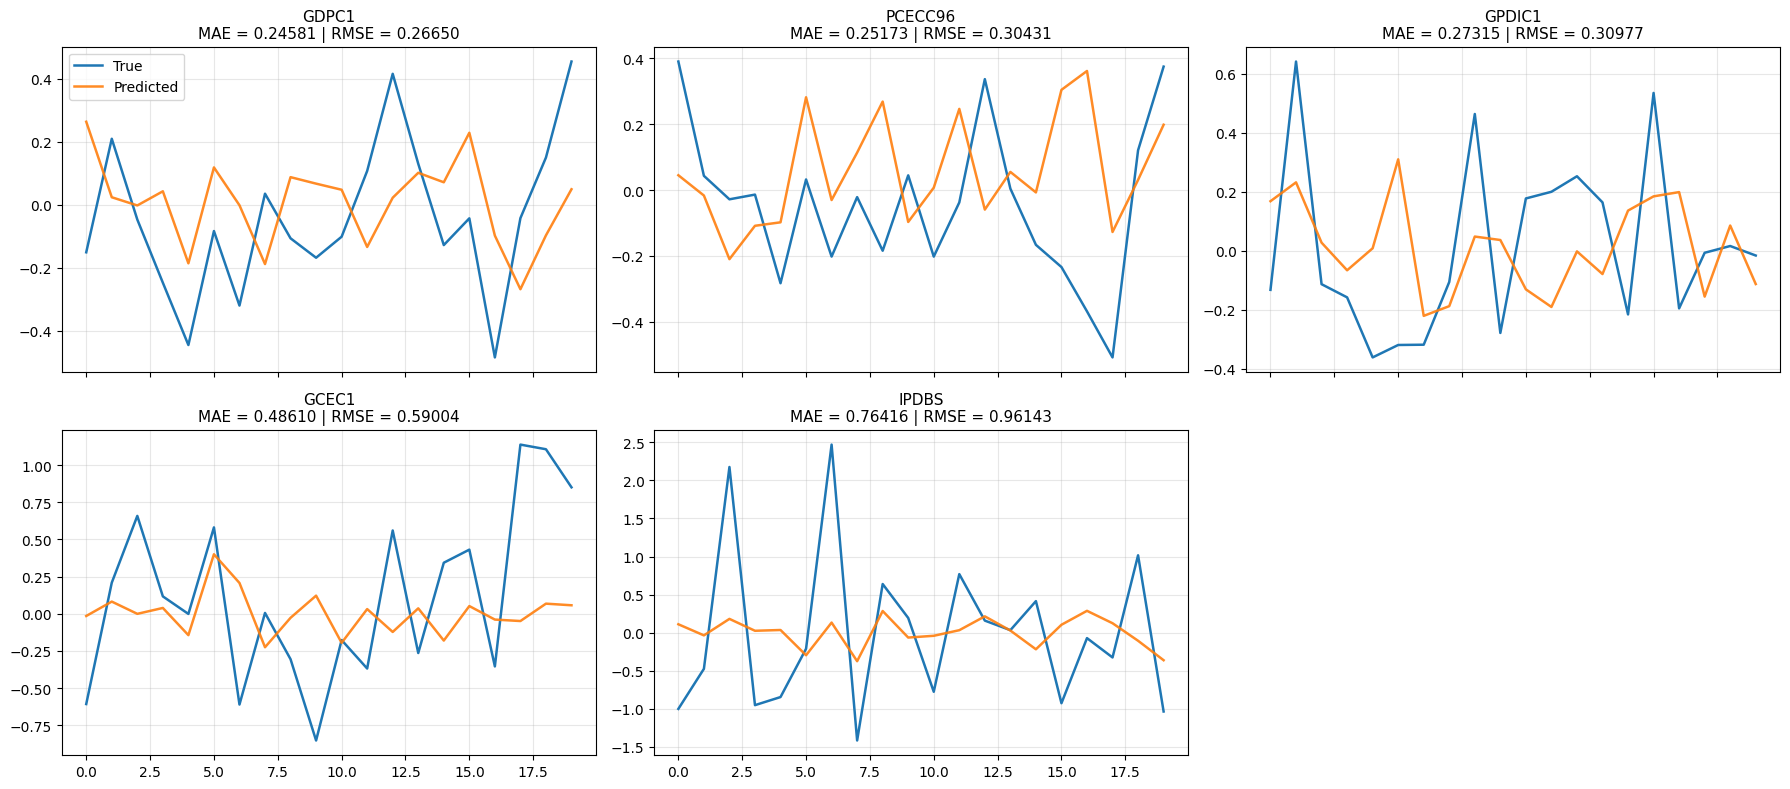


All direct multi-step forecasts and plots saved successfully.
Original shape: (1, 5, 20)
Stacked shape: (5, 20)

=== Horizon 1 (Direct Forecast t+1) ===
Overall Mean MAE : 0.4042
Overall Mean RMSE: 0.5536


In [14]:
# ==================== Rolling Forecast Loop ====================
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'        # 'L-BFGS-B' or 'Powell'
inits = [2,2,2,2]              # Initial values for weight parameters
final_model_type = 'rnn'   # <--- CHANGE HERE: 'dnn', 'lstm', 'gru', 'transformer'
num_layers = 1
hidden_dim = 128
dropout = 0.3
target_epochs = 200
batch_size    = 64
lr            = 1e-5
patience     = 10


# forecast_test_MIDAS = np.zeros((Q, T_test))
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        # Update training data (expanding window)
        latest_end = T_train + T_val + t
        X_H_train = X_H[:, :latest_end * d1 * d2]
        X_M_train = X_M[:, :latest_end * d2]
        Y_train = Y[:, :latest_end]

        # Retrain full model
        nn_model, fitted_values, w_high, w_med = three_freq_midas_lagged_neural(
            Y_train, X_M_train, X_H_train,
            d1=d1, d2=d2, k=k,
            Weight_choice=Weight_choice,
            device=device,
            Q=Q,
            final_model=final_model_type,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            epochs=target_epochs,
            batch_size=batch_size,
            lr=lr,
            patience=patience,
            verbose=False,
            eval_horizon=eval_horizon_curr,
            method=method,inits=inits
        )
        print('Optimized w_high (first 10):', np.round(w_high[:10], 4))
        print('Optimized w_med:', np.round(w_med, 4))
        # Prepare one-step-ahead inputs
        target_horizon = eval_horizon_curr + 1
        start_idx_h = (latest_end - target_horizon - k + 1) * d1 * d2
        X_H_test_block = X_H[:, start_idx_h: start_idx_h + k*d1*d2]

        start_idx_m = (latest_end - target_horizon - k + 1) * d2
        X_M_test_block = X_M[:, start_idx_m: start_idx_m + d2]

        Y_hist_lag = Y[:, (latest_end - target_horizon - k + 1) :(latest_end - target_horizon + 1) ]

        # Forecast
        forecast_MIDAS = midas_forecast_neural(
            model=nn_model,
            X_low_hist=Y_hist_lag,
            X_med=X_M_test_block,
            X_high=X_H_test_block,
            k=k, d1=d1, d2=d2,
            w_high=w_high, w_med=w_med,
            device=device
        )

        forecasts_multi[i, :, t] = forecast_MIDAS

# Compute errors
Y_true = Y[:Q, T_train + T_val: T_train + T_val + T_test]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS/graph/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_horizon{h+1}.png',
        title_prefix=f'{Weight_choice}_{final_model_type} Forecast (Horizon = {h+1})'
    )
print("\nAll direct multi-step forecasts and plots saved successfully.")

print("Original shape:", forecasts_multi.shape)           # should be (4,5,20)

# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
stacked = forecasts_multi.transpose(0, 2, 1).reshape(eval_horizon_len*5, 20)
# or equivalently: forecasts_multi.reshape(4*5, 20).T    → same result

print("Stacked shape:", stacked.shape)                    # (20, 20)

# Create column names (optional but very helpful)
col_names = []
for start in range(20):
    col_names.append(f"T+{start+1}")

index_names = []
for horizon in range(eval_horizon_len):
    for variable in range(5):
        index_names.append(f"horizon{horizon+1}_variable{variable+1}")

df = pd.DataFrame(
    stacked,
    index=index_names,
    columns=col_names
)

# Save
os.makedirs('../result/MIDAS/csv', exist_ok=True)
csv_path = f'../result/MIDAS/csv/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_all_horizons.csv'
df.to_csv(csv_path, index_label='horizon')

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)
    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")


----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----


Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_h

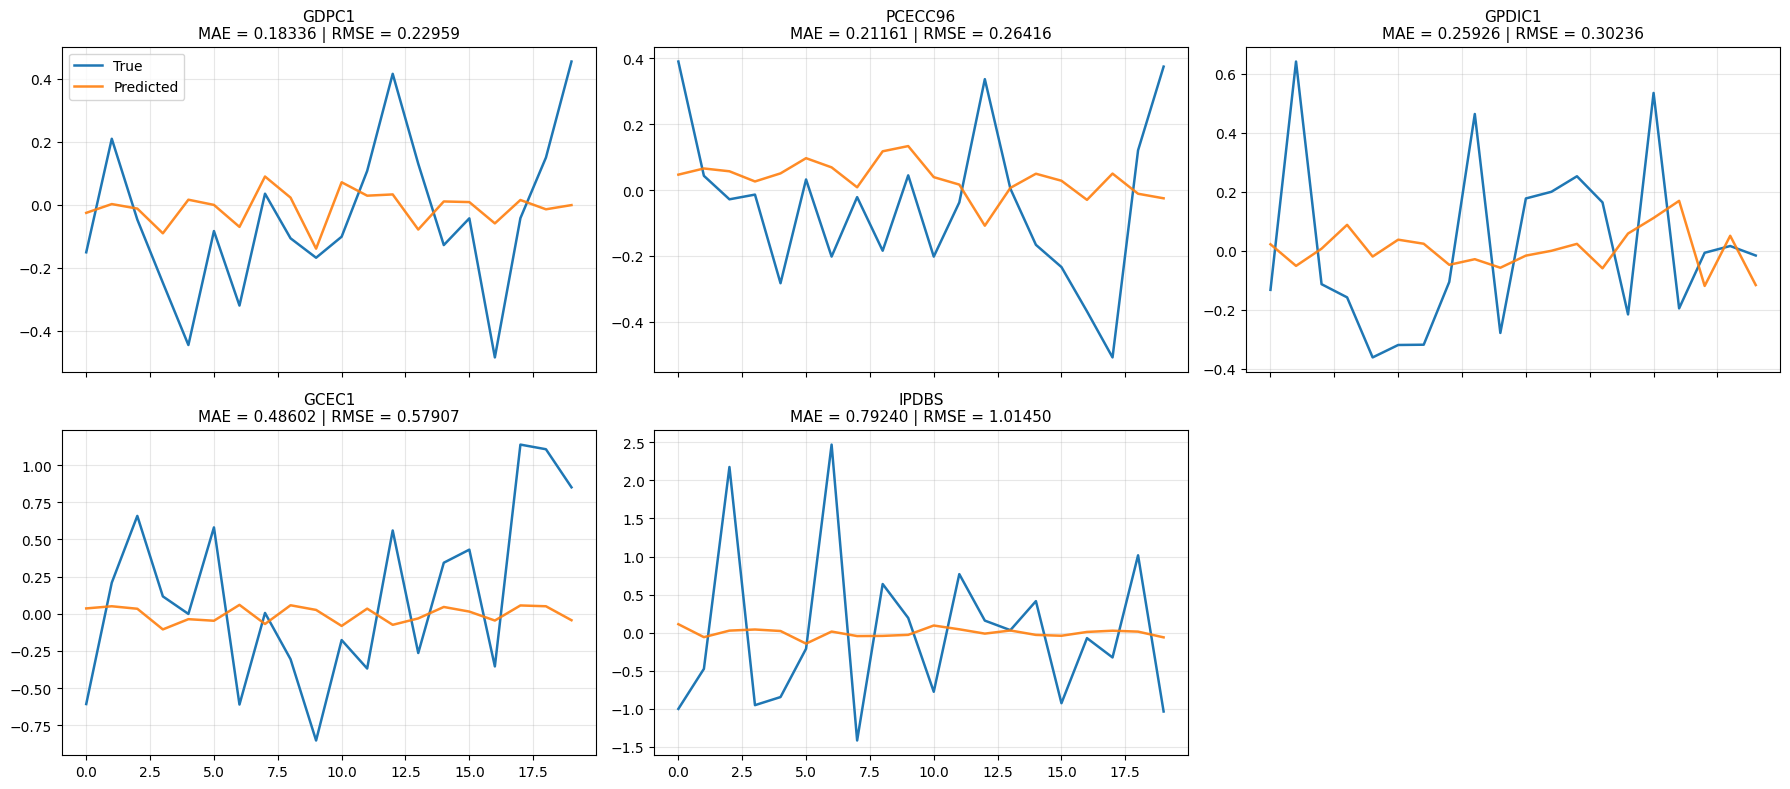


All direct multi-step forecasts and plots saved successfully.
Original shape: (1, 5, 20)
Stacked shape: (5, 20)

=== Horizon 1 (Direct Forecast t+1) ===
Overall Mean MAE : 0.3865
Overall Mean RMSE: 0.5619


In [5]:
# ==================== Rolling Forecast Loop ====================
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'        # 'L-BFGS-B' or 'Powell'
inits = [2,2,2,2]              # Initial values for weight parameters
final_model_type = 'lstm'   # <--- CHANGE HERE: 'dnn', 'lstm', 'gru', 'transformer'
num_layers = 1
hidden_dim = 128
dropout = 0.3
target_epochs = 200
batch_size    = 64
lr            = 1e-5
patience     = 10


# forecast_test_MIDAS = np.zeros((Q, T_test))
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        # Update training data (expanding window)
        latest_end = T_train + T_val + t
        X_H_train = X_H[:, :latest_end * d1 * d2]
        X_M_train = X_M[:, :latest_end * d2]
        Y_train = Y[:, :latest_end]

        # Retrain full model
        nn_model, fitted_values, w_high, w_med = three_freq_midas_lagged_neural(
            Y_train, X_M_train, X_H_train,
            d1=d1, d2=d2, k=k,
            Weight_choice=Weight_choice,
            device=device,
            Q=Q,
            final_model=final_model_type,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            epochs=target_epochs,
            batch_size=batch_size,
            lr=lr,
            patience=patience,
            verbose=False,
            eval_horizon=eval_horizon_curr,
            method=method,inits=inits
        )
        print('Optimized w_high (first 10):', np.round(w_high[:10], 4))
        print('Optimized w_med:', np.round(w_med, 4))
        # Prepare one-step-ahead inputs
        target_horizon = eval_horizon_curr + 1
        start_idx_h = (latest_end - target_horizon - k + 1) * d1 * d2
        X_H_test_block = X_H[:, start_idx_h: start_idx_h + k*d1*d2]

        start_idx_m = (latest_end - target_horizon - k + 1) * d2
        X_M_test_block = X_M[:, start_idx_m: start_idx_m + d2]

        Y_hist_lag = Y[:, (latest_end - target_horizon - k + 1) :(latest_end - target_horizon + 1) ]

        # Forecast
        forecast_MIDAS = midas_forecast_neural(
            model=nn_model,
            X_low_hist=Y_hist_lag,
            X_med=X_M_test_block,
            X_high=X_H_test_block,
            k=k, d1=d1, d2=d2,
            w_high=w_high, w_med=w_med,
            device=device
        )

        forecasts_multi[i, :, t] = forecast_MIDAS

# Compute errors
Y_true = Y[:Q, T_train + T_val: T_train + T_val + T_test]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS/graph/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_horizon{h+1}.png',
        title_prefix=f'{Weight_choice}_{final_model_type} Forecast (Horizon = {h+1})'
    )
print("\nAll direct multi-step forecasts and plots saved successfully.")

print("Original shape:", forecasts_multi.shape)           # should be (4,5,20)

# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
stacked = forecasts_multi.transpose(0, 2, 1).reshape(eval_horizon_len*5, 20)
# or equivalently: forecasts_multi.reshape(4*5, 20).T    → same result

print("Stacked shape:", stacked.shape)                    # (20, 20)

# Create column names (optional but very helpful)
col_names = []
for start in range(20):
    col_names.append(f"T+{start+1}")

index_names = []
for horizon in range(eval_horizon_len):
    for variable in range(5):
        index_names.append(f"horizon{horizon+1}_variable{variable+1}")

df = pd.DataFrame(
    stacked,
    index=index_names,
    columns=col_names
)

# Save
os.makedirs('../result/MIDAS/csv', exist_ok=True)
csv_path = f'../result/MIDAS/csv/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_all_horizons.csv'
df.to_csv(csv_path, index_label='horizon')

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)
    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")


----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0

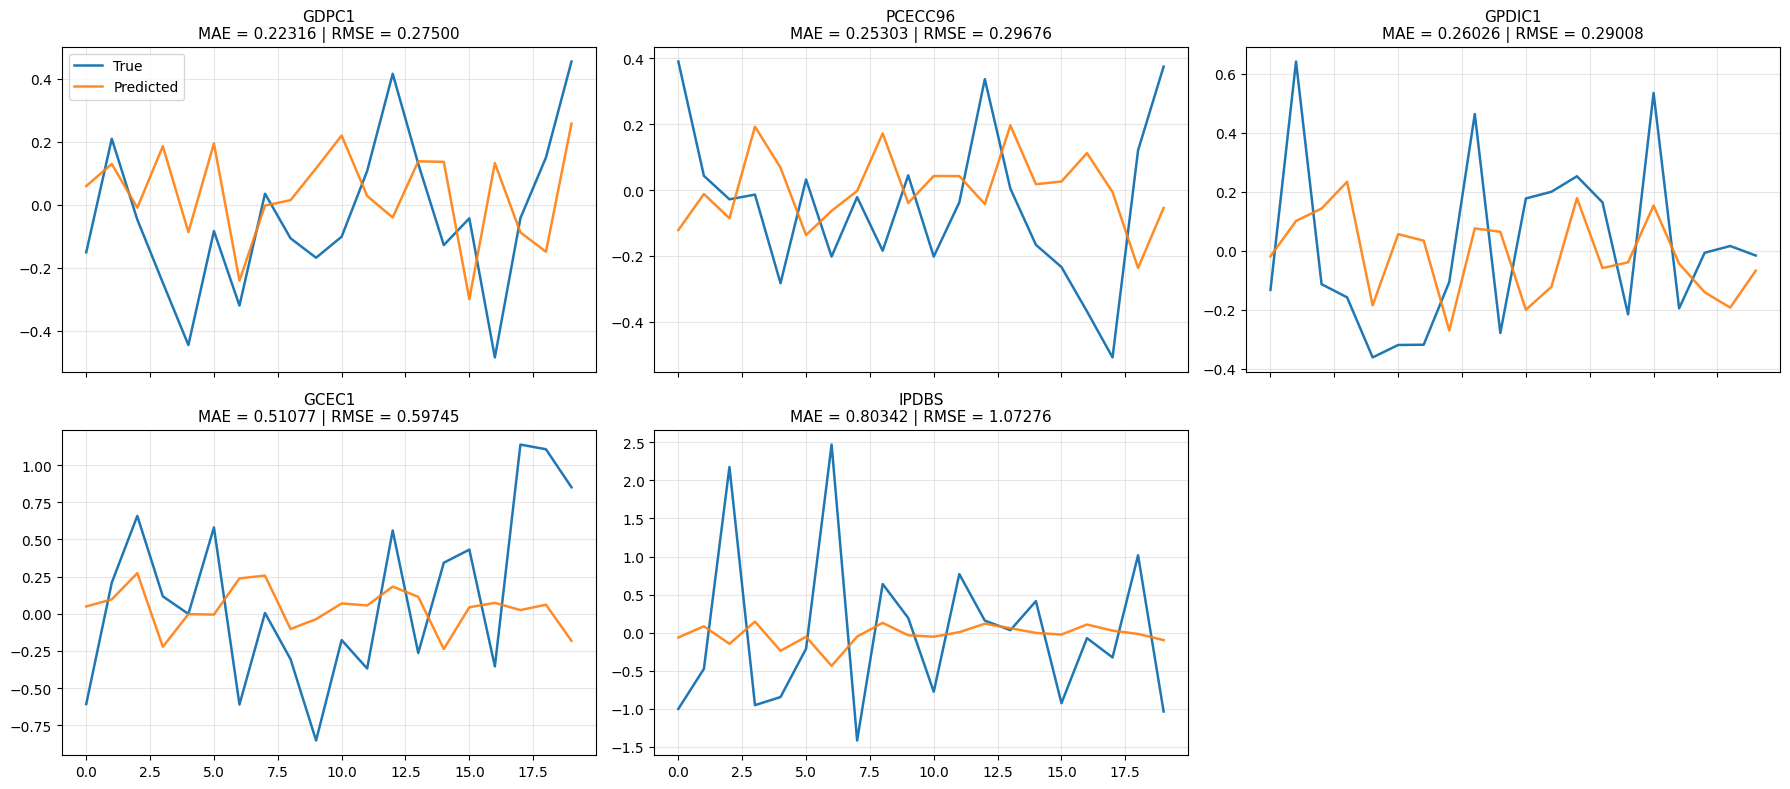


All direct multi-step forecasts and plots saved successfully.
Original shape: (1, 5, 20)
Stacked shape: (5, 20)

=== Horizon 1 (Direct Forecast t+1) ===
Overall Mean MAE : 0.4101
Overall Mean RMSE: 0.5926


In [ ]:
# ==================== Rolling Forecast Loop ====================
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'        # 'L-BFGS-B' or 'Powell'
inits = [2,2,2,2]              # Initial values for weight parameters
final_model_type = 'dnn'   # <--- CHANGE HERE: 'dnn','rnn', 'lstm', 'gru', 'transformer'
num_layers = 1
hidden_dim = 128
dropout = 0.3
target_epochs = 200
batch_size    = 64
lr            = 1e-5
patience     = 10


# forecast_test_MIDAS = np.zeros((Q, T_test))
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        # Update training data (expanding window)
        latest_end = T_train + T_val + t
        X_H_train = X_H[:, :latest_end * d1 * d2]
        X_M_train = X_M[:, :latest_end * d2]
        Y_train = Y[:, :latest_end]

        # Retrain full model
        nn_model, fitted_values, w_high, w_med = three_freq_midas_lagged_neural(
            Y_train, X_M_train, X_H_train,
            d1=d1, d2=d2, k=k,
            Weight_choice=Weight_choice,
            device=device,
            Q=Q,
            final_model=final_model_type,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            epochs=target_epochs,
            batch_size=batch_size,
            lr=lr,
            patience=patience,
            verbose=False,
            eval_horizon=eval_horizon_curr,
            method=method,inits=inits
        )
        print('Optimized w_high (first 10):', np.round(w_high[:10], 4))
        print('Optimized w_med:', np.round(w_med, 4))
        # Prepare one-step-ahead inputs
        target_horizon = eval_horizon_curr + 1
        start_idx_h = (latest_end - target_horizon - k + 1) * d1 * d2
        X_H_test_block = X_H[:, start_idx_h: start_idx_h + k*d1*d2]

        start_idx_m = (latest_end - target_horizon - k + 1) * d2
        X_M_test_block = X_M[:, start_idx_m: start_idx_m + d2]

        Y_hist_lag = Y[:, (latest_end - target_horizon - k + 1) :(latest_end - target_horizon + 1) ]

        # Forecast
        forecast_MIDAS = midas_forecast_neural(
            model=nn_model,
            X_low_hist=Y_hist_lag,
            X_med=X_M_test_block,
            X_high=X_H_test_block,
            k=k, d1=d1, d2=d2,
            w_high=w_high, w_med=w_med,
            device=device
        )

        forecasts_multi[i, :, t] = forecast_MIDAS

# Compute errors
Y_true = Y[:Q, T_train + T_val: T_train + T_val + T_test]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS/graph/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_horizon{h+1}.png',
        title_prefix=f'{Weight_choice}_{final_model_type} Forecast (Horizon = {h+1})'
    )
print("\nAll direct multi-step forecasts and plots saved successfully.")

print("Original shape:", forecasts_multi.shape)           # should be (4,5,20)

# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
stacked = forecasts_multi.transpose(0, 2, 1).reshape(eval_horizon_len*5, 20)
# or equivalently: forecasts_multi.reshape(4*5, 20).T    → same result

print("Stacked shape:", stacked.shape)                    # (20, 20)

# Create column names (optional but very helpful)
col_names = []
for start in range(20):
    col_names.append(f"T+{start+1}")

index_names = []
for horizon in range(eval_horizon_len):
    for variable in range(5):
        index_names.append(f"horizon{horizon+1}_variable{variable+1}")

df = pd.DataFrame(
    stacked,
    index=index_names,
    columns=col_names
)

# Save
os.makedirs('../result/MIDAS/csv', exist_ok=True)
csv_path = f'../result/MIDAS/csv/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_all_horizons.csv'
df.to_csv(csv_path, index_label='horizon')

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)
    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

Post-COVID19

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from Baseline import set_seed
from utils import (root_mean_squared_error, mean_absolute_error, print_stats, plot_forecasts_multi)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


np.printoptions(precision=4, suppress=True)
np.set_printoptions(precision=4, suppress=True)
set_seed(42)

#data parameters
d1 = 20
d2 = 3
P1 = 13
P2 = 56
QP3 = 9
Q = 5

T = 208
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

#hyperparameters
r1_list =  list(range(1, 9))
r2_list = list(range(1, 7))
# k_list =  list(range(1, 7)) #lag
k_list = [1, 4, 8, 12]
r1_num = len(r1_list)
r2_num = len(r2_list)
k_num = len(k_list)
epochs = 200

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print_stats(Y, 'Y')
print_stats(X_M, 'X_M')
print_stats(X_H, 'X_H')

# --- Data Splitting ---
X_H_train = X_H[:, :(T_train + T_val) * d1 * d2]
X_M_train = X_M[:, :(T_train + T_val) * d2]
Y_train = Y[:, :(T_train + T_val)]

X_H_test = X_H[:, T_train * d1 * d2 + T_val * d1 * d2:]
X_M_test = X_M[:, T_train * d2 + T_val * d2:]
Y_test = Y[:, T_train + T_val:]

T 208 T_H: 12480 T_M: 624
T_train: 168 T_val: 20 T_test: 20
--- Y ---
Shape: (9, 208)
Stat: max=9.0831  min=-8.9814  mean=-0.0000  std=1.0000
--- X_M ---
Shape: (56, 624)
Stat: max=24.6946  min=-24.2957  mean=0.0000  std=1.0000
--- X_H ---
Shape: (13, 12480)
Stat: max=30.8164  min=-33.0392  mean=-0.0000  std=1.0000



----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0

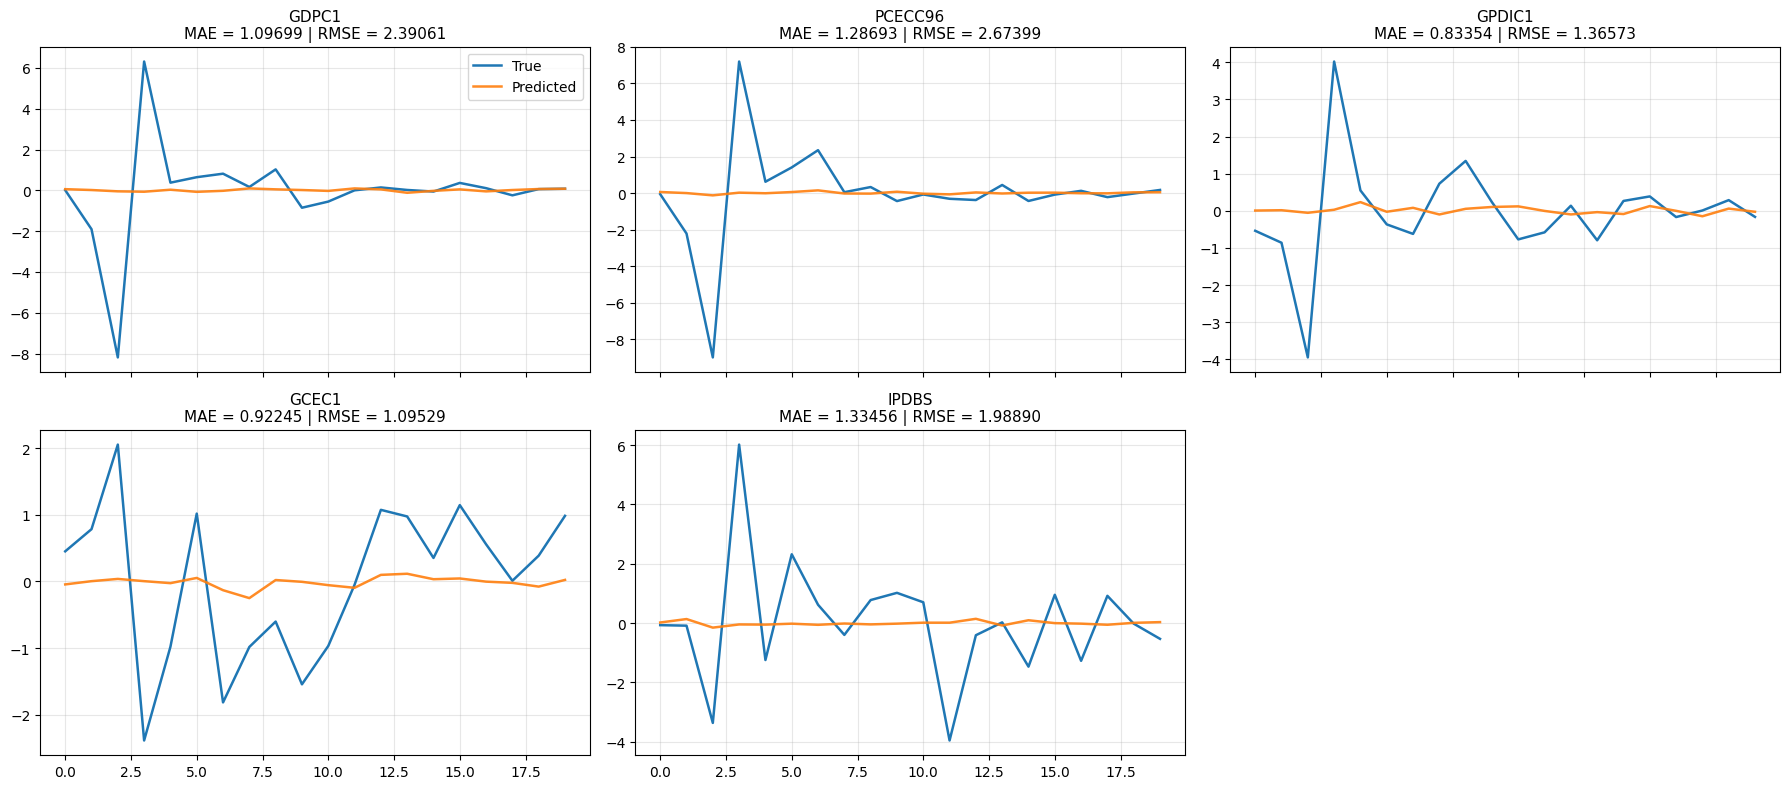


All direct multi-step forecasts and plots saved successfully.
Original shape: (1, 5, 20)
Stacked shape: (5, 20)

=== Horizon 1 (Direct Forecast t+1) ===
Overall Mean MAE : 1.0949
Overall Mean RMSE: 1.9943


In [ ]:
# ==================== Rolling Forecast Loop ====================
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'        # 'L-BFGS-B' or 'Powell'
inits = [2,2,2,2]              # Initial values for weight parameters
final_model_type = 'lstm'   # <--- CHANGE HERE: 'dnn', 'lstm', 'gru', 'transformer'
num_layers = 1
hidden_dim = 128
dropout = 0.3
target_epochs = 200
batch_size    = 64
lr            = 1e-5
patience     = 10


# forecast_test_MIDAS = np.zeros((Q, T_test))
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        # Update training data (expanding window)
        latest_end = T_train + T_val + t
        X_H_train = X_H[:, :latest_end * d1 * d2]
        X_M_train = X_M[:, :latest_end * d2]
        Y_train = Y[:, :latest_end]

        # Retrain full model
        nn_model, fitted_values, w_high, w_med = three_freq_midas_lagged_neural(
            Y_train, X_M_train, X_H_train,
            d1=d1, d2=d2, k=k,
            Weight_choice=Weight_choice,
            device=device,
            Q=Q,
            final_model=final_model_type,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            epochs=target_epochs,
            batch_size=batch_size,
            lr=lr,
            patience=patience,
            verbose=False,
            eval_horizon=eval_horizon_curr,
            method=method,inits=inits
        )
        print('Optimized w_high (first 10):', np.round(w_high[:10], 4))
        print('Optimized w_med:', np.round(w_med, 4))
        # Prepare one-step-ahead inputs
        target_horizon = eval_horizon_curr + 1
        start_idx_h = (latest_end - target_horizon - k + 1) * d1 * d2
        X_H_test_block = X_H[:, start_idx_h: start_idx_h + k*d1*d2]

        start_idx_m = (latest_end - target_horizon - k + 1) * d2
        X_M_test_block = X_M[:, start_idx_m: start_idx_m + d2]

        Y_hist_lag = Y[:, (latest_end - target_horizon - k + 1) :(latest_end - target_horizon + 1) ]

        # Forecast
        forecast_MIDAS = midas_forecast_neural(
            model=nn_model,
            X_low_hist=Y_hist_lag,
            X_med=X_M_test_block,
            X_high=X_H_test_block,
            k=k, d1=d1, d2=d2,
            w_high=w_high, w_med=w_med,
            device=device
        )

        forecasts_multi[i, :, t] = forecast_MIDAS

# Compute errors
Y_true = Y[:Q, T_train + T_val: T_train + T_val + T_test]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS/graph/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_horizon{h+1}.png',
        title_prefix=f'{Weight_choice}_{final_model_type} Forecast (Horizon = {h+1})'
    )
print("\nAll direct multi-step forecasts and plots saved successfully.")

print("Original shape:", forecasts_multi.shape)           # should be (4,5,20)

# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
stacked = forecasts_multi.transpose(0, 2, 1).reshape(eval_horizon_len*5, 20)
# or equivalently: forecasts_multi.reshape(4*5, 20).T    → same result

print("Stacked shape:", stacked.shape)                    # (20, 20)

# Create column names (optional but very helpful)
col_names = []
for start in range(20):
    col_names.append(f"T+{start+1}")

index_names = []
for horizon in range(eval_horizon_len):
    for variable in range(5):
        index_names.append(f"horizon{horizon+1}_variable{variable+1}")

df = pd.DataFrame(
    stacked,
    index=index_names,
    columns=col_names
)

# Save
os.makedirs('../result/MIDAS/csv', exist_ok=True)
csv_path = f'../result/MIDAS/csv/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_all_horizons.csv'
df.to_csv(csv_path, index_label='horizon')

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)
    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")


----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----


Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_high (first 10): [0.0002 0.0159 0.0299 0.0421 0.0526 0.0614 0.0684 0.0736 0.0771 0.0789]
Optimized w_med: [0.019  0.9621 0.019 ]
Optimized w_h

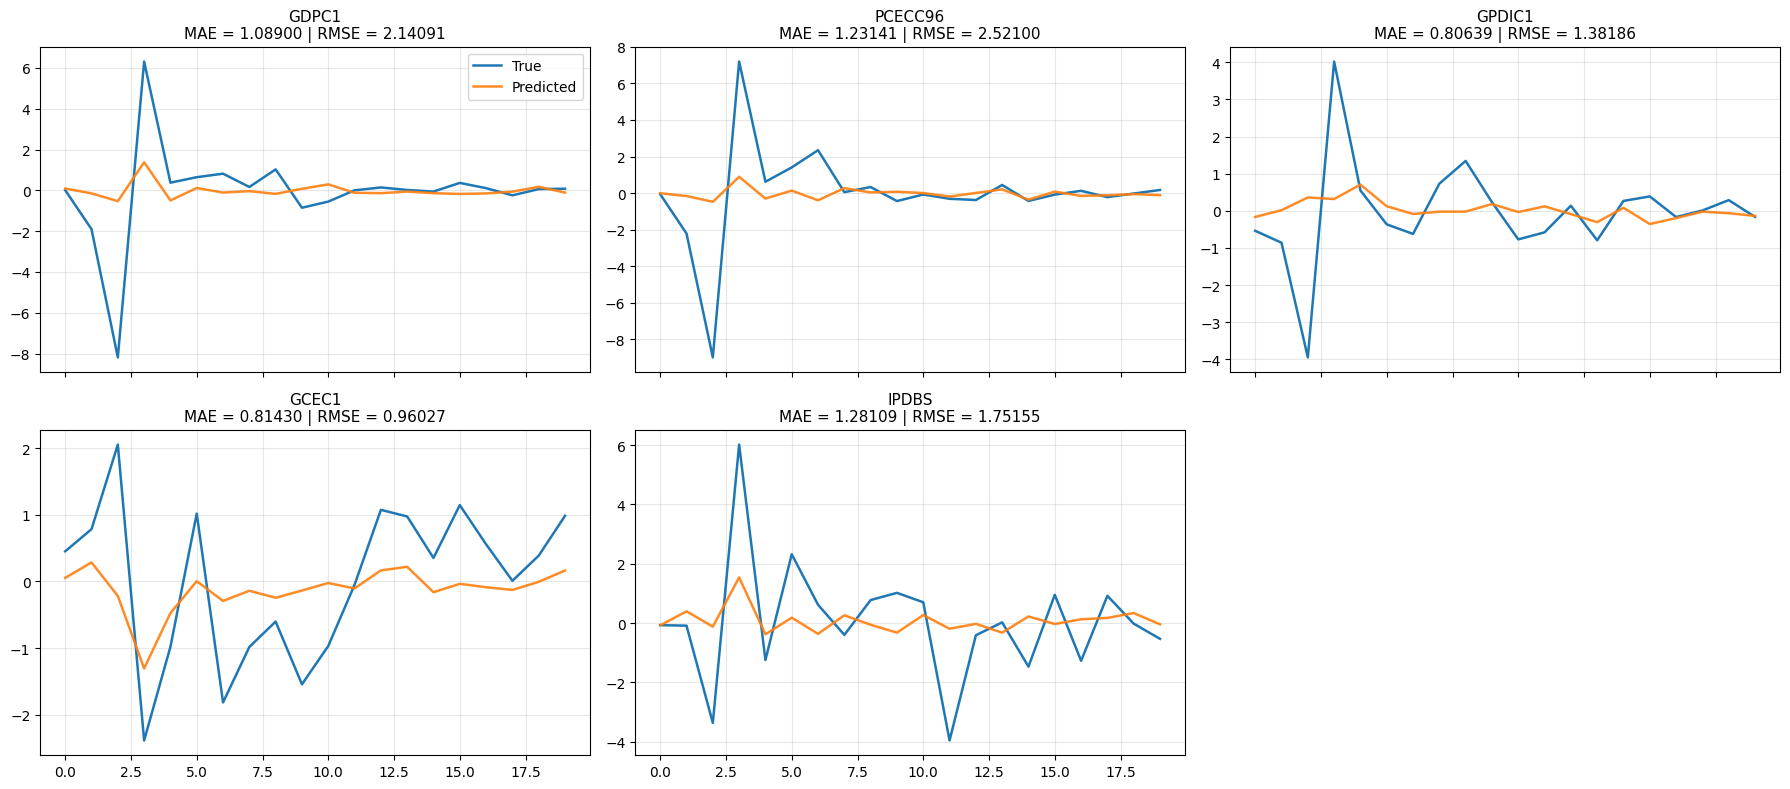


All direct multi-step forecasts and plots saved successfully.
Original shape: (1, 5, 20)
Stacked shape: (5, 20)

=== Horizon 1 (Direct Forecast t+1) ===
Overall Mean MAE : 1.0444
Overall Mean RMSE: 1.8351


In [7]:
# ==================== Rolling Forecast Loop ====================
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'        # 'L-BFGS-B' or 'Powell'
inits = [2,2,2,2]              # Initial values for weight parameters
final_model_type = 'dnn'   # <--- CHANGE HERE: 'dnn','rnn', 'lstm', 'gru', 'transformer'
num_layers = 1
hidden_dim = 128
dropout = 0.3
target_epochs = 200
batch_size    = 64
lr            = 1e-5
patience     = 10


# forecast_test_MIDAS = np.zeros((Q, T_test))
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        # Update training data (expanding window)
        latest_end = T_train + T_val + t
        X_H_train = X_H[:, :latest_end * d1 * d2]
        X_M_train = X_M[:, :latest_end * d2]
        Y_train = Y[:, :latest_end]

        # Retrain full model
        nn_model, fitted_values, w_high, w_med = three_freq_midas_lagged_neural(
            Y_train, X_M_train, X_H_train,
            d1=d1, d2=d2, k=k,
            Weight_choice=Weight_choice,
            device=device,
            Q=Q,
            final_model=final_model_type,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            epochs=target_epochs,
            batch_size=batch_size,
            lr=lr,
            patience=patience,
            verbose=False,
            eval_horizon=eval_horizon_curr,
            method=method,inits=inits
        )
        print('Optimized w_high (first 10):', np.round(w_high[:10], 4))
        print('Optimized w_med:', np.round(w_med, 4))
        # Prepare one-step-ahead inputs
        target_horizon = eval_horizon_curr + 1
        start_idx_h = (latest_end - target_horizon - k + 1) * d1 * d2
        X_H_test_block = X_H[:, start_idx_h: start_idx_h + k*d1*d2]

        start_idx_m = (latest_end - target_horizon - k + 1) * d2
        X_M_test_block = X_M[:, start_idx_m: start_idx_m + d2]

        Y_hist_lag = Y[:, (latest_end - target_horizon - k + 1) :(latest_end - target_horizon + 1) ]

        # Forecast
        forecast_MIDAS = midas_forecast_neural(
            model=nn_model,
            X_low_hist=Y_hist_lag,
            X_med=X_M_test_block,
            X_high=X_H_test_block,
            k=k, d1=d1, d2=d2,
            w_high=w_high, w_med=w_med,
            device=device
        )

        forecasts_multi[i, :, t] = forecast_MIDAS

# Compute errors
Y_true = Y[:Q, T_train + T_val: T_train + T_val + T_test]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS/graph/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_horizon{h+1}.png',
        title_prefix=f'{Weight_choice}_{final_model_type} Forecast (Horizon = {h+1})'
    )
print("\nAll direct multi-step forecasts and plots saved successfully.")

print("Original shape:", forecasts_multi.shape)           # should be (4,5,20)

# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
# Option A – most readable: 20 horizons × 20 series (4 starts × 5 samples)
# Order: start0-sample0, start0-sample1, ..., start0-sample4, start1-sample0, ...
stacked = forecasts_multi.transpose(0, 2, 1).reshape(eval_horizon_len*5, 20)
# or equivalently: forecasts_multi.reshape(4*5, 20).T    → same result

print("Stacked shape:", stacked.shape)                    # (20, 20)

# Create column names (optional but very helpful)
col_names = []
for start in range(20):
    col_names.append(f"T+{start+1}")

index_names = []
for horizon in range(eval_horizon_len):
    for variable in range(5):
        index_names.append(f"horizon{horizon+1}_variable{variable+1}")

df = pd.DataFrame(
    stacked,
    index=index_names,
    columns=col_names
)

# Save
os.makedirs('../result/MIDAS/csv', exist_ok=True)
csv_path = f'../result/MIDAS/csv/{Weight_choice}_{final_model_type}_k{k}L{num_layers}w{hidden_dim}epoch{target_epochs}_all_horizons.csv'
df.to_csv(csv_path, index_label='horizon')

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)
    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")
